# LSCTS
+ large scale Chinese short text summarization dataset)
+ 中文社交媒体文本，LCSTS数据集的特点是文本篇幅较短，并且存在噪声
+ 训练集大小	2400000
+ 验证集大小	10000
+ 测试集大小	1000

In [1]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer 

model = None
tokenizer = None
device = "cuda" if torch.cuda.is_available() else "cpu" 

with torch.no_grad():
    # model_ckpt = "google/pegasus-cnn_dailymail" 
    model_ckpt = '../../../resources/embedding/google_pegasus-cnn-dm'
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt) 
    model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device) 

/home/users/sunhongchao/miniconda3/envs/bot-mvp/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import datasets
import pandas as pd
from datasets import Dataset, load_dataset

# from transformers import BertTokenizer
# TokenModel = "../../../resources/embedding/t5-large"
# tokenizer = BertTokenizer.from_pretrained(TokenModel)

max_input_length = 512
max_target_length = 128
 
lcsts_part_1=pd.read_table('../../../resources/dataset/lscts/DATA/PART_II.txt', header=None,
                           warn_bad_lines=True, error_bad_lines=False, sep='<[/d|/s|do|su|sh][^a].*>', encoding='utf-8') # PART I  too big, use PART II instead
lcsts_part_1=lcsts_part_1[0].dropna()
lcsts_part_1=lcsts_part_1.reset_index(drop=True)
lcsts_part_1=pd.concat([lcsts_part_1[1::2].reset_index(drop=True), lcsts_part_1[::2].reset_index(drop=True)], axis=1)
lcsts_part_1.columns=['document', 'summary']
 
lcsts_part_2=pd.read_table('../../../resources/dataset/lscts/DATA/PART_II.txt', header=None,
                           warn_bad_lines=True, error_bad_lines=False, sep='<[/d|/s|do|su|sh][^a].*>', encoding='utf-8')
lcsts_part_2=lcsts_part_2[0].dropna()
lcsts_part_2=lcsts_part_2.reset_index(drop=True)
lcsts_part_2=pd.concat([lcsts_part_2[1::2].reset_index(drop=True), lcsts_part_2[::2].reset_index(drop=True)], axis=1)
lcsts_part_2.columns=['document', 'summary']
 
dataset_train = Dataset.from_dict(lcsts_part_1)
dataset_valid = Dataset.from_dict(lcsts_part_2)

d_len = [len(tokenizer.encode(s['document'])) for s in dataset_train] 
s_len = [len(tokenizer.encode(s['summary'])) for s in dataset_train] 

/home/users/sunhongchao/miniconda3/envs/bot-mvp/lib/python3.6/site-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


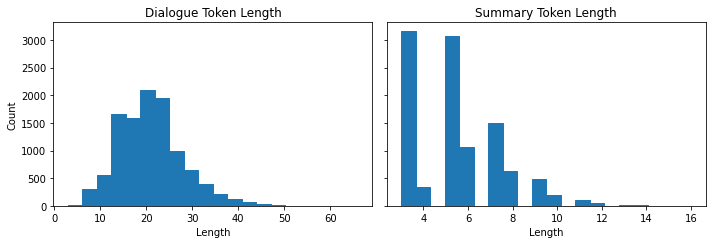

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0") 
axes[0].set_title("Dialogue Token Length") 
axes[0].set_xlabel("Length") 
axes[0].set_ylabel("Count") 
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0") 
axes[1].set_title("Summary Token Length") 
axes[1].set_xlabel("Length") 
plt.tight_layout() 

In [4]:
def preprocess_function(examples):
    inputs = [str(doc) for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    inputs = [str(doc) for doc in examples["summary"]]
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(inputs, max_length=max_target_length, truncation=True)
 
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets_t = dataset_train.map(preprocess_function, batched=True)
tokenized_datasets_v = dataset_valid.map(preprocess_function, batched=True)
 
tokenized_datasets = datasets.DatasetDict({"train":tokenized_datasets_t,"validation": tokenized_datasets_v})
print(tokenized_datasets)
print(tokenized_datasets['train'][0])

100%|██████████| 11/11 [00:00<00:00, 13.97ba/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10666
    })
    validation: Dataset({
        features: ['document', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10666
    })
})
{'document': '日前，方舟子发文直指林志颖旗下爱碧丽推销假保健品，引起哗然。调查发现，爱碧丽没有自己的生产加工厂。其胶原蛋白饮品无核心研发，全部代工生产。号称有“逆生长”功效的爱碧丽“梦幻奇迹限量组”售价高达1080元，实际成本仅为每瓶4元！', 'summary': '林志颖公司疑涉虚假营销无厂房无研发', 'input_ids': [110, 105, 108, 105, 108, 105, 108, 105, 108, 105, 468, 105, 227, 105, 468, 105, 227, 105, 32936, 105, 108, 105, 914, 105, 147, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [110, 105, 1]}
